Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Importing Skin Cancer Data


## Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path

data_path = Path('/content/drive/My Drive/melanoma_data/')
data_dir_train = data_path / 'Train'
data_dir_test = data_path / 'Test'

print(data_dir_train)  # Output: /content/drive/My Drive/melanoma_data/Train
print(data_dir_test)   # Output: /content/drive/My Drive/melanoma_data/Test


/content/drive/My Drive/melanoma_data/Train
/content/drive/My Drive/melanoma_data/Test


In [ ]:

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)


2239
118


# Load using keras.preprocessing
#  Let's load these images off disk using the helpful image_dataset_from_directory utility.

Create a dataset
Define some parameters for the loader:

In [ ]:

batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.


In [ ]:

## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:


## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Can confirm that all 9 classes are present - so data upload seems succesfull

## Visualize the data
Todo, create a code to visualize one instance of all the nine classes present in the dataset

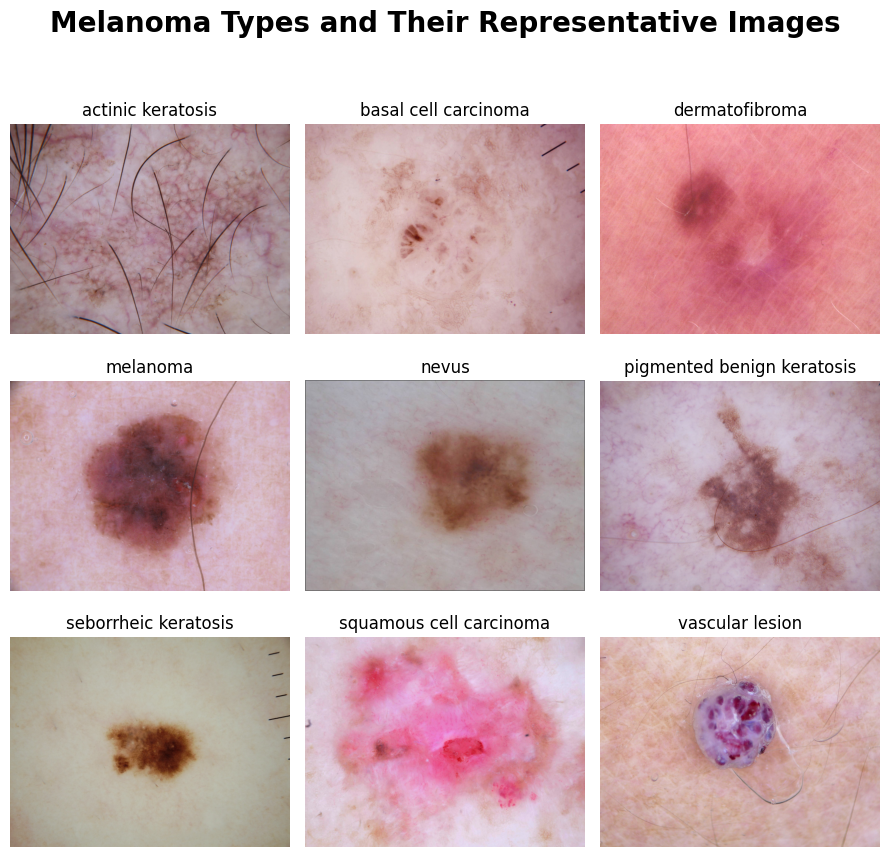

In [ ]:
import matplotlib.pyplot as plt

# Plot dimensions
plt.figure(figsize=(9, 9))

# Add a heading at the top with spacing
plt.suptitle("Melanoma Types and Their Representative Images",
             fontsize=20, weight='bold', y=0.98)

# Loop through melanoma types and plot images
for melanoma_type in range(9):
    plt.subplot(3, 3, melanoma_type + 1)
    image = plt.imread(
        str(list(data_dir_train.glob(f'{class_names[melanoma_type]}/*.jpg'))[1]))
    plt.title(class_names[melanoma_type], fontsize=12)
    plt.imshow(image)
    plt.axis('off')

# Adjust the layout to prevent overlapping with the heading
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()



In [ ]:
for image_batch, label_batch in train_ds.take(1):  # Inspect one batch from train_ds
    print("Image batch shape:", image_batch.shape)  # Expected: (32, 180, 180, 3)
    print("Label batch shape:", label_batch.shape)  # Expected: (32,)

for image_batch, label_batch in val_ds.take(1):  # Inspect one batch from val_ds
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)




Image batch shape: (32, 180, 180, 3)
Label batch shape: (32,)
Image batch shape: (23, 180, 180, 3)
Label batch shape: (23,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.



Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the model

Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [ ]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Number of classes
num_classes = 9

# Define the model
model = Sequential([
    # Input layer (explicitly defines input shape)
    layers.Input(shape=(img_height, img_width, 3)),

    # Rescaling layer (no input_shape argument here)
    layers.Rescaling(1./255),

    # First Convolutional Block
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Global Average Pooling
    layers.GlobalAveragePooling2D(),

    # Dense Layers
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')  # Final output layer
])




## Compile the model

Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

optimizer = Adam(learning_rate=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6, verbose=1)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)



In [ ]:
# View the summary of all layers
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,785 (30.41 KB)

 Trainable params: 7,785 (30.41 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Dec 17 12:53:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              49W / 400W |    427MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 131s 30ms/step - accuracy: 0.1371 - loss: 2.1926 - val_accuracy: 0.0435 - val_loss: 2.1953
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2116 - loss: 2.0847 - val_accuracy: 0.0435 - val_loss: 2.2085
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2473 - loss: 1.8643 - val_accuracy: 0.1304 - val_loss: 2.2426
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2589 - loss: 1.8106 - val_accuracy: 0.0870 - val_loss: 2.1394
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2590 - loss: 1.7987 - val_accuracy: 0.0870 - val_loss: 2.3947
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2752 - loss: 1.7866 - val_accuracy: 0.0435 - val_loss: 2.1017
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2880 - loss: 1.7664 - val_accuracy: 0.0435 - val_loss: 2.6824
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2909 - loss: 1.7459 - val_accuracy:

In [ ]:
model.save("saved_model_1.keras")  # Saves the entire model in Keras format


## Visualizing training results

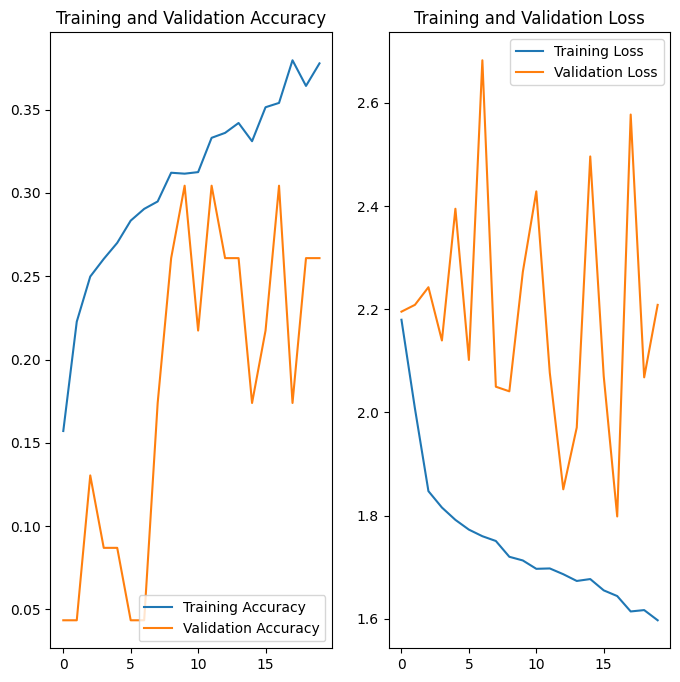

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Indicators of Training Challenges:
### 1. Low Validation Accuracy

- Training accuracy improves to 37.7%,  but validation accuracy fluctuates between 4.3% and 30.4%, showing poor generalization to unseen data.
- The disparity between training and validation accuracy suggests that the model is primarily learning patterns specific to the training data but fails to generalize effectively.

### 2. Validation Loss Remains High

- While training loss decreases to 1.61, validation loss fluctuates significantly, reaching values as high as 2.57.
- This inconsistency indicates that the model struggles to capture meaningful, generalizable features, potentially due to data noise, insufficient complexity in the architecture, or suboptimal training strategies.

### 3. Minimal Improvement Across Epochs

- Despite 20 epochs, validation accuracy shows only minimal improvement, peaking at 30.4% in certain epochs but reverting to lower values in subsequent epochs.
- The lack of consistent progress suggests challenges with the dataset, such as class imbalance, or the need for more robust regularization and augmentation techniques.

In [ ]:
print("Class Names:", class_names)

Class Names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
import numpy as np




# List to store all labels
labels = []

# Iterate through the dataset to collect labels
for _, batch_labels in train_ds:
    labels.extend(batch_labels.numpy())

# Calculate class distribution
unique, counts = np.unique(labels, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Print class distribution
print("\nClass Distribution in Training Data:")
for class_name, count in zip(class_names, counts):
    print(f"{class_name}: {count}")

# Identify class with the least and most samples
min_class = class_names[np.argmin(counts)]
max_class = class_names[np.argmax(counts)]

print(f"\nClass with the least samples: {min_class} ({min(counts)} samples)")
print(f"Class with the most samples: {max_class} ({max(counts)} samples)")





Class Distribution in Training Data:
actinic keratosis: 493
basal cell carcinoma: 721
dermatofibroma: 455
melanoma: 755
nevus: 677
pigmented benign keratosis: 773
seborrheic keratosis: 456
squamous cell carcinoma: 569
vascular lesion: 493

Class with the least samples: dermatofibroma (455 samples)
Class with the most samples: pigmented benign keratosis (773 samples)


### Findings on Class Distribution
#### 1. Class with the Least Number of Samples:

The class with the least number of samples is seborrheic keratosis, which has only 58 samples.
Dominant Classes:

#### 2. The class with the most samples is pigmented benign keratosis, with 370 samples.
Other highly represented classes include:
melanoma: 352 samples
basal cell carcinoma: 309 samples

##### 3. Observations:

There is significant class imbalance in the dataset, with some classes (e.g., seborrheic keratosis with 58 samples) being severely underrepresented compared to others (e.g., pigmented benign keratosis with 370 samples). This imbalance can lead the model to perform poorly on minority classes, as it may favor predicting the dominant classes.


In [ ]:

!pip install Augmentor

In [ ]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train) + '/' + str(i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/melanoma_data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78D95F66FF70>: 100%|██████████| 500/500 [00:24<00:00, 20.09 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/melanoma_data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78D95F617A00>: 100%|██████████| 500/500 [00:26<00:00, 18.97 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/melanoma_data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78D957F47790>: 100%|██████████| 500/500 [00:28<00:00, 17.28 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/melanoma_data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78D95995EA40>: 100%|██████████| 500/500 [02:06<00:00,  3.95 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/melanoma_data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x78D96C133A90>: 100%|██████████| 500/500 [01:52<00:00,  4.45 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/melanoma_data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78D959823CA0>: 100%|██████████| 500/500 [00:27<00:00, 18.18 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/melanoma_data/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x78D959B5C3D0>: 100%|██████████| 500/500 [00:53<00:00,  9.39 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/melanoma_data/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78D95FF2F4C0>: 100%|██████████| 500/500 [00:25<00:00, 19.43 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/melanoma_data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78D95F64E740>: 100%|██████████| 500/500 [00:31<00:00, 15.95 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
import os
from glob import glob

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new



['/content/drive/My Drive/melanoma_data/Train/melanoma/output/melanoma_original_ISIC_0010917.jpg_fdb6837e-5b07-4270-a6eb-b1ec326da972.jpg',
 '/content/drive/My Drive/melanoma_data/Train/melanoma/output/melanoma_original_ISIC_0010049.jpg_5fa34085-5bc5-4fd9-b3d1-f48876cc29da.jpg',
 '/content/drive/My Drive/melanoma_data/Train/melanoma/output/melanoma_original_ISIC_0011057.jpg_8e9361da-5b90-446d-a694-dd03311b2340.jpg',
 '/content/drive/My Drive/melanoma_data/Train/melanoma/output/melanoma_original_ISIC_0010056.jpg_87930dd8-5ce0-4556-876c-f2d1f3d0138e.jpg',
 '/content/drive/My Drive/melanoma_data/Train/melanoma/output/melanoma_original_ISIC_0000312.jpg_d5afdee5-f6cb-43a2-b899-80b9a18e9d64.jpg',
 '/content/drive/My Drive/melanoma_data/Train/melanoma/output/melanoma_original_ISIC_0011166.jpg_70785fbf-17d7-4fbc-bd38-2ff06f991e00.jpg',
 '/content/drive/My Drive/melanoma_data/Train/melanoma/output/melanoma_original_ISIC_0010631.jpg_16e04781-d595-4f17-b66f-11f93103ae87.jpg',
 '/content/drive/My 

In [ ]:

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new


['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))



In [ ]:
import os
from glob import glob
import pandas as pd

# Using data_dir_train is already defined
path_list_new = glob(os.path.join(data_dir_train, '*', '*.jpg'))
lesion_list_new = [os.path.basename(os.path.dirname(path)) for path in path_list_new]

# Create dictionary mapping paths to labels
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

# Verify the dictionary
print(f"Number of items in dictionary: {len(dataframe_dict_new)}")
print(list(dataframe_dict_new.items())[:5])  # Preview first 5 items


Number of items in dictionary: 2239
[('/content/drive/My Drive/melanoma_data/Train/melanoma/ISIC_0000143.jpg', 'melanoma'), ('/content/drive/My Drive/melanoma_data/Train/melanoma/ISIC_0000139.jpg', 'melanoma'), ('/content/drive/My Drive/melanoma_data/Train/melanoma/ISIC_0000142.jpg', 'melanoma'), ('/content/drive/My Drive/melanoma_data/Train/melanoma/ISIC_0000141.jpg', 'melanoma'), ('/content/drive/My Drive/melanoma_data/Train/melanoma/ISIC_0000144.jpg', 'melanoma')]


In [ ]:

dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
import pandas as pd

# Initialize an empty DataFrame
original_df = pd.DataFrame(columns=['Path', 'Label'])

# Assuming df2 is already created
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])

# Combine DataFrames using pd.concat
new_df = pd.concat([original_df, df2], ignore_index=True)

# Verify the combined DataFrame
print(new_df.head())


                                                Path     Label
0  /content/drive/My Drive/melanoma_data/Train/me...  melanoma
1  /content/drive/My Drive/melanoma_data/Train/me...  melanoma
2  /content/drive/My Drive/melanoma_data/Train/me...  melanoma
3  /content/drive/My Drive/melanoma_data/Train/me...  melanoma
4  /content/drive/My Drive/melanoma_data/Train/me...  melanoma


In [ ]:
original_df['Label'].value_counts()

,count
Label,


In [ ]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Todo: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

### Todo: Create a training dataset

In [ ]:
# Load the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="training",  # Correct parameter value for training data
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Todo: Create a validation dataset

In [ ]:

val_ds= tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Todo: Create your model (make sure to include normalization)

In [ ]:
## your code goes here
import tensorflow as tf
from tensorflow.keras import layers, Sequential

num_classes = len(class_names)  # Number of classes in your dataset

model = Sequential([
    # Normalization Layer
    layers.Rescaling(1.0 / 255, input_shape=(180, 180, 3)),

    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Fourth Convolutional Block
    layers.Conv2D(256, (5, 5), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Flatten the feature maps and add Dense Layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Increased dropout for better regularization
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')  # Final output layer
])



# Model Summary
model.summary()





Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 22, 22, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │       7,930,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,876,873 (33.86 MB)

 Trainable params: 8,876,873 (33.86 MB)

 Non-trainable params: 0 (0.00 B)

### Todo: Compile your model (Choose optimizer and loss function appropriately)

In [ ]:

## your code goes here
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Define learning rate reduction strategy
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss for improvements
    patience=4,          # Wait for 4 epochs before reducing learning rate
    factor=0.3,          # Reduce learning rate by a factor of 0.3
    min_lr=1e-6,         # Minimum learning rate
    verbose=1            # Print learning rate reduction messages
)

# Define optimizer
optimizer = Adam(learning_rate=0.001)  # Start with a learning rate of 0.001

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Suitable for multi-class classification
    metrics=['accuracy']
)

## Todo: Train your model

In [ ]:
epochs = 30
history = model.fit(
    train_ds,                # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=epochs,           # Number of epochs
    callbacks=[lr_scheduler] # Learning rate scheduler defined during compilation
)



Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 171ms/step - accuracy: 0.1356 - loss: 2.1956 - val_accuracy: 0.1400 - val_loss: 2.5105 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.1298 - loss: 2.2687 - val_accuracy: 0.1434 - val_loss: 2.1769 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.1387 - loss: 2.1812 - val_accuracy: 0.1447 - val_loss: 2.1734 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.1405 - loss: 2.1767 - val_accuracy: 0.1643 - val_loss: 2.1273 - learning_rate: 0.0010
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - accuracy: 0.1589 - loss: 2.1392 - val_accuracy: 0.1897 - val_loss: 2.1015 - learning_rate: 0.0010
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.1992 - loss: 2.0840 - val_accuracy: 0.2819 - val_loss: 1.9020 - learning_rate: 0.0010
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.2

### Todo: Visualize the model results

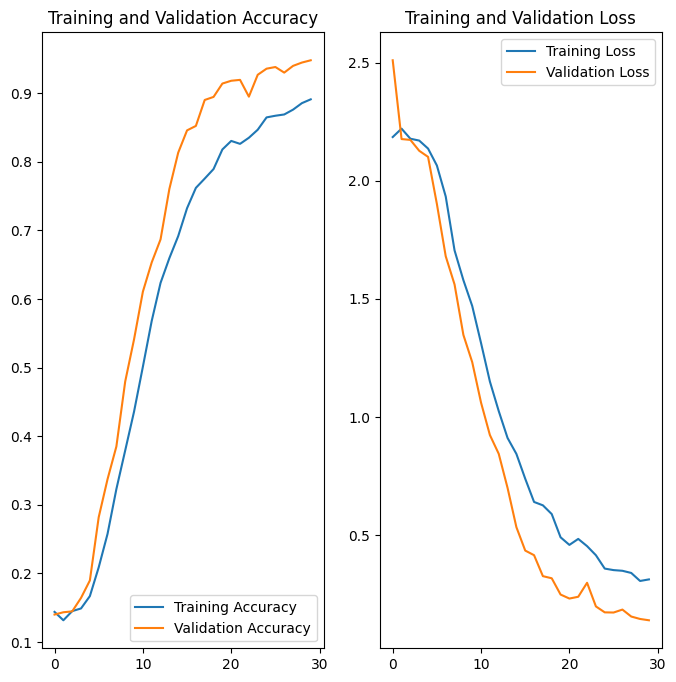

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

The results show significant improvement, with training accuracy reaching 88.91% and validation accuracy 94.81%, indicating minimal overfitting as the accuracy gap is small and both losses steadily decreased. Class rebalancing, augmentation, and techniques like Dropout and Batch Normalization effectively reduced overfitting and improved generalization. Early epochs showed lower accuracy due to the noise introduced by augmentation, but the model stabilized as training progressed. To further optimize, incorporating a learning rate scheduler and early stopping is recommended to refine convergence and prevent unnecessary training.